In [3]:
from Features.birds import *
from Features.sweden_map import *
from Features.weather import *
import pandas as pd
import numpy as np
from datetime import datetime, timedelta


In [8]:
API_tomorrow_weather(lon=lng, lat=lat, days=7)

{'latitude': 57.732597,
 'longitude': 13.398376,
 'generationtime_ms': 0.2206563949584961,
 'utc_offset_seconds': 3600,
 'timezone': 'Europe/Berlin',
 'timezone_abbreviation': 'GMT+1',
 'elevation': 165.0,
 'daily_units': {'time': 'iso8601',
  'temperature_2m_mean': '°C',
  'precipitation_sum': 'mm',
  'weather_code': 'wmo code',
  'wind_speed_10m_mean': 'km/h'},
 'daily': {'time': ['2025-12-18',
   '2025-12-19',
   '2025-12-20',
   '2025-12-21',
   '2025-12-22',
   '2025-12-23',
   '2025-12-24'],
  'temperature_2m_mean': [5.6, 7.0, 6.5, 3.8, 0.5, 0.7, -1.1],
  'precipitation_sum': [0.6, 5.3, 1.4, 0.0, 0.0, 0.0, 0.0],
  'weather_code': [51, 53, 51, 3, 3, 3, 3],
  'wind_speed_10m_mean': [17.5, 18.6, 13.7, 6.7, 8.9, 13.0, 8.4]}}

## Bird data

What we want: 
lat, lon, num obs, time (maybe), obsReviewed

from api:


In [82]:
#1
def drop_unused_columns(df: pd.DataFrame) -> pd.DataFrame:
    cols_keep = ["OBSERVATION COUNT", "LATITUDE", "LONGITUDE", "OBSERVATION DATE", "TIME OBSERVATIONS STARTED"]

    return df[cols_keep]

# new stuff, hope it not breaks! 
def patch_bird_data_holes(bird_df: pd.DataFrame, b_type: str) -> pd.DataFrame:
    daily_dict = API_bird_data(bird_type=b_type, backfill=True)
    daily_df = pd.DataFrame(daily_dict)

    daily_df.rename(columns={
        "obsDt": "OBSERVATION DATE",
        "lat": "LATITUDE",
        "lng": "LONGITUDE",
        "howMany": "OBSERVATION COUNT"
    }, inplace=True)

    drop_cols = ["speciesCode","comName","sciName","locId","locName",
                 "obsValid","obsReviewed","locationPrivate","subId"]
    daily_df.drop(columns=[c for c in drop_cols if c in daily_df.columns], inplace=True)

    ret_df = pd.concat([bird_df, daily_df], ignore_index=True)
    return ret_df


def fill_na_times(df: pd.DataFrame) -> pd.DataFrame:
    times = pd.to_datetime(df['TIME OBSERVATIONS STARTED'], format='%H:%M:%S', errors='coerce')

    # Calculate mean, round to nearest Hour ('H'), extract time
    mean_time = times.mean().round('h').time()
    df = df.fillna({"TIME OBSERVATIONS STARTED": mean_time})
    return df

def sort_bird_df_date_time(df:pd.DataFrame) -> pd.DataFrame:
    #df['TIME OBSERVATIONS STARTED'] = pd.to_datetime(df['TIME OBSERVATIONS STARTED'], format='%H:%M:%S', errors='coerce')
    df.sort_values(by=['OBSERVATION DATE', 'TIME OBSERVATIONS STARTED'], inplace=True)
    return df

def filter_by_year(df: pd.DataFrame, year: int = 2011) -> pd.DataFrame:
    df['OBSERVATION DATE'] = pd.to_datetime(df['OBSERVATION DATE'])
    return df[df['OBSERVATION DATE'].dt.year >= year]

def daily_bird_call(today:str, b_type:str) -> pd.DataFrame:
    daily_dict=API_bird_data(bird_type=b_type)
    daily_df = pd.DataFrame(daily_dict)
   
    daily_df.rename(columns={"obsDt":"OBSERVATION DATE", "lat": "LATITUDE", "lng": "LONGITUDE", "howMany": "OBSERVATION COUNT"}, inplace=True)
    daily_df.drop(columns=["speciesCode","comName", "sciName", "locId", "locName", "obsValid", "obsReviewed", "locationPrivate", "subId"], inplace=True) # what is the howMany column
    
    daily_df['OBSERVATION DATE'] = pd.to_datetime(daily_df['OBSERVATION DATE']) # Convert to datetime
    daily_df['TIME OBSERVATIONS STARTED'] = daily_df['OBSERVATION DATE'].dt.strftime('%H:%M:%S') # Extract time as H-M-S
    daily_df['OBSERVATION DATE'] = daily_df['OBSERVATION DATE'].dt.strftime('%Y-%m-%d') # Keep only date string
    # filter by day; 
    daily_df = daily_df[daily_df['OBSERVATION DATE'] == today]
    
    # if it is empty, return empty df with cols: ["OBSERVATION COUNT", "LATITUDE", "LONGITUDE", "OBSERVATION DATE", "TIME OBSERVATIONS STARTED"]
    if daily_df.empty:
        daily_df = pd.DataFrame(columns=["OBSERVATION COUNT", "LATITUDE", "LONGITUDE", "OBSERVATION DATE", "TIME OBSERVATIONS STARTED"])
    return daily_df # need a standard thing to return if empty

def map_bird_region(df: pd.DataFrame) -> pd.DataFrame:
    map=SwedenMap()
    regions = []
    for index, row in df.iterrows():
        lat = row['LATITUDE']
        lng = row['LONGITUDE']
        region = map.point_to_region(lon=lng,lat=lat)
        regions.append(region)
    df['REGION'] = regions
    return df


def merge_weather_data(bird_df: pd.DataFrame, weather_df: pd.DataFrame) -> pd.DataFrame:
    # 1. Pivot weather_df so variables (Temp, Rain, etc.) become columns
    # Assumes 'daily' column contains actual lists. If strings, use ast.literal_eval first.
    weather_pivoted = weather_df.pivot(index='REGION', columns='daily_units', values='daily')

    # 2. Explode the lists into individual rows (pandas >= 1.3.0)
    weather_exploded = weather_pivoted.explode(list(weather_pivoted.columns))

    # 3. Rename columns to match requirements
    weather_exploded.rename(columns={
        'iso8601': 'OBSERVATION DATE',
        '°C': 'TEMPERATURE',
        'mm': 'RAIN',
        'km/h': 'WIND',
        'wmo code': 'WEATHERCODE'
    }, inplace=True)
    
    # 4. Reset index to turn REGION back into a column
    weather_exploded.reset_index(inplace=True)

    # 5. Ensure date formats match for merging
    bird_df['OBSERVATION DATE'] = bird_df['OBSERVATION DATE'].astype(str)
    weather_exploded['OBSERVATION DATE'] = weather_exploded['OBSERVATION DATE'].astype(str)

    # 6. Merge left to keep all bird observations
    merged_df = pd.merge(bird_df, weather_exploded, on=['REGION', 'OBSERVATION DATE'], how='right')

    return merged_df


def add_weather_to_bird(today: str, bird_df: pd.DataFrame) -> pd.DataFrame:
    map=SwedenMap()
    weather_df = pd.DataFrame()
    for key, (lat, lng) in map.centroid_dict.items():
        weather_dict, COLS = historical_weather_download(start_date=today, lon=lng, lat=lat)
        temp_weather_df = pd.DataFrame(weather_dict)
        temp_weather_df["REGION"] = key
        weather_df = pd.concat([weather_df, temp_weather_df], ignore_index=True)
    
    # we have COLS = ["OBSERVATION DATE", "TEMPERATURE", "RAIN", "WIND", "WEATHERCODE"]
    # from the dataframe, the daily col needs to be exploaded into separate columns with the same index
    
    merged_df = merge_weather_data(bird_df, weather_df)
    return merged_df

def add_normalized_year(df: pd.DataFrame, start_year: int = 2011) -> pd.DataFrame:
    df['OBSERVATION DATE'] = pd.to_datetime(df['OBSERVATION DATE'])
    df['YEAR'] = df['OBSERVATION DATE'].dt.year - start_year
    return df

def one_hot_months(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['MONTH'] = pd.to_datetime(df['OBSERVATION DATE']).dt.month
    month_dummies = pd.get_dummies(df['MONTH'], prefix='MONTH')
    all_months = [f"MONTH_{m}" for m in range(1, 13)] # Force all months 1–12 to exist
    month_dummies = month_dummies.reindex(columns=all_months, fill_value=False)
    df = pd.concat([df, month_dummies], axis=1)
    df.drop(columns=['MONTH'], inplace=True)
    return df

def clean_bird_data(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # 1) Normalize counts
    df['OBSERVATION COUNT'] = (
        df['OBSERVATION COUNT']
        .replace('X', 1)
        .fillna(0)
        .astype(int)
    )
    df['OBSERVATION DATE'] = df['OBSERVATION DATE'].astype(str)

    # 2) Index of row to KEEP (max count per REGION + DATE)
    idx = (
        df.groupby(['REGION', 'OBSERVATION DATE'])['OBSERVATION COUNT']
        .idxmax()
    )

    # 3) Take those rows → keeps ALL original columns
    result = df.loc[idx].copy()

    # 4) Compute summed counts
    summed_counts = (
        df.groupby(['REGION', 'OBSERVATION DATE'])['OBSERVATION COUNT']
        .sum()
        .values
    )

    # 5) Overwrite count column
    result['OBSERVATION COUNT'] = summed_counts

    return result.reset_index(drop=True)


def backfill_weather(start_date: str) -> pd.DataFrame:
    map = SwedenMap()
    region_dict = map.centroid_dict
    region_df = pd.DataFrame(region_dict.items(), columns=['REGION', 'COORDINATES']) #lat, lon
    full_df = pd.DataFrame()
    for reg, coord in region_df.iterrows():
        data, labels = historical_weather_download(start_date=start_date, lon=coord["COORDINATES"][1], lat=coord["COORDINATES"][0])
        df_temp = pd.DataFrame(data=data)
        df_temp["REGION"] = coord["REGION"]
        weather_pivoted = df_temp.pivot(index='REGION', columns='daily_units', values='daily')
        weather_exploded = weather_pivoted.explode(list(weather_pivoted.columns))

        # 3. Rename columns to match requirements
        weather_exploded.rename(columns={
            'iso8601': 'OBSERVATION DATE',
            '°C': 'TEMPERATURE',
            'mm': 'RAIN',
            'km/h': 'WIND',
            'wmo code': 'WEATHERCODE'
        }, inplace=True)
        
        # 4. Reset index to turn REGION back into a column
        weather_exploded.reset_index(inplace=True)
        weather_exploded['OBSERVATION DATE'] = weather_exploded['OBSERVATION DATE'].astype(str)
        full_df = pd.concat([full_df, weather_exploded], ignore_index=True)
    return full_df 

        
def merge_historic_weather(bird_df: pd.DataFrame, weather_df: pd.DataFrame) -> pd.DataFrame:
    bird_df = bird_df.copy()
    weather_df = weather_df.copy()
    bird_df['OBSERVATION DATE'] = ( pd.to_datetime(bird_df['OBSERVATION DATE']).dt.strftime('%Y-%m-%d'))
    weather_df['OBSERVATION DATE'] = weather_df['OBSERVATION DATE'].astype(str)
    
    # Weather defines the full (REGION, DATE) grid
    return weather_df.merge(
        bird_df,
        on=['REGION', 'OBSERVATION DATE'],
        how='left'
    )

def historical():
    """
    Get the historical weather and bird obs to add to the Hopsworks dataframe
    """
    df_golden = pd.read_csv(
    'Data/ebd_SE_goleag_smp_relOct-2025_extracted/ebd_SE_goleag_smp_relOct-2025.txt', 
    sep='\t', 
    low_memory=False, # Prevents DtypeWarnings on mixed-type columns in large files
    parse_dates=['OBSERVATION DATE', 'LAST EDITED DATE'] # Optional: converts dates immediately
)

    df_whteag = pd.read_csv(
        "Data/ebd_SE_whteag_smp_relOct-2025_extracted/ebd_SE_whteag_smp_relOct-2025.txt",
        sep='\t', 
        low_memory=False, # Prevents DtypeWarnings on mixed-type columns in large files
        parse_dates=['OBSERVATION DATE', 'LAST EDITED DATE'] # Optional: converts dates immediately
    )
    birds = {"whteag": df_whteag,"goleag": df_golden}
    weather_historic = backfill_weather(start_date="2025-10-01")
    final_bird_dfs = pd.DataFrame()
    for name, df in birds.items():

        df_dropped = drop_unused_columns(df)
        
        df_patched_holes = patch_bird_data_holes(df_dropped, b_type=name)
        df_na_times_filled = fill_na_times(df_patched_holes)
        df_sorted_date = sort_bird_df_date_time(df_na_times_filled)
        df_filtered_year = filter_by_year(df_sorted_date, year=2011)
        df_mapped_region = map_bird_region(df_filtered_year)


        cleaned_bird = clean_bird_data(df_mapped_region)
        df_bird = merge_historic_weather(cleaned_bird, weather_historic)
        df_bird["BIRD TYPE"] = name
        

        # fill nan vals in obs to 0 
        df_bird['OBSERVATION COUNT'] = df_bird['OBSERVATION COUNT'].fillna(0).astype(int)
        df_norm_year = add_normalized_year(df_bird, start_year=2011)
        df_1h_months = one_hot_months(df_norm_year)
        df_1h_months['OBSERVATION DATE'] = ( pd.to_datetime(df_1h_months['OBSERVATION DATE']).dt.strftime('%Y-%m-%d'))

        final_bird_dfs = pd.concat([final_bird_dfs, df_1h_months], ignore_index=True)

    final_bird_dfs.drop(columns=["LATITUDE", "LONGITUDE"], inplace=True)
    return final_bird_dfs


def daily():
    """
    Get the weather and bird obs to add to the Hopsworks dataframe
    """
    # Get today's date in 'YYYY-MM-DD' format
    TODAY = datetime.now().strftime('%Y-%m-%d')
    bird_types = ["whteag", "goleag"]
    reigon_dict = SwedenMap().centroid_dict
    weather_df = pd.DataFrame()
    # get wheather for today
    for name, (lat,lon) in reigon_dict.items():
        weather_dict, COLS = historical_weather_download(start_date=TODAY, lon=lon, lat=lat)
        temp_weather_df = pd.DataFrame(weather_dict)
        temp_weather_df["REGION"] = name
        temp_weather_df["OBSERVATION DATE"] = TODAY
        weather_df = pd.concat([weather_df, temp_weather_df], ignore_index=True)

    # for each bird type, get today's bird data
    ret_df = pd.DataFrame()

    for idx, b_type in enumerate(bird_types):
        today_bird = daily_bird_call(today=TODAY, b_type=b_type)
        
        if not today_bird.empty:
            today_bird_mapped = map_bird_region(today_bird)
            merged_df = merge_weather_data(today_bird_mapped, weather_df)
        else: 
            # create empty df with cols of merged df
            merged_df_emtpy = pd.DataFrame(columns=["OBSERVATION COUNT", "LATITUDE", "LONGITUDE", "OBSERVATION DATE", 
                    "TIME OBSERVATIONS STARTED", "REGION"])
            merged_df = merge_weather_data(merged_df_emtpy, weather_df)
        merged_df.drop(columns=["LATITUDE", "LONGITUDE"], inplace=True)
        merged_df['BIRD TYPE'] = b_type
        merged_df.fillna({"OBSERVATION COUNT": 0}, inplace=True)
        ret_df = pd.concat([ret_df, merged_df], ignore_index=True)
    
    # one hot and add norm year
    ret_df = add_normalized_year(ret_df, start_year=2011)
    ret_df = one_hot_months(ret_df)
    
    return ret_df

def features(days: int = 7) -> pd.DataFrame:
    """
    Get the features for the model
    """
    TODAY = datetime.now().strftime('%Y-%m-%d')
    reigon_dict = SwedenMap().centroid_dict
    weather_df = pd.DataFrame()
    # get wheather for today
    ret_df = pd.DataFrame()
    for name, (lat,lon) in reigon_dict.items():
        weather_dict = API_tomorrow_weather(days=days, lon=lon, lat=lat)
        temp_weather_df = pd.DataFrame(weather_dict)
        temp_weather_df["REGION"] = name
        
        weather_pivoted = temp_weather_df.pivot(index='REGION', columns='daily_units', values='daily')
        weather_exploded = weather_pivoted.explode(list(weather_pivoted.columns))

        # 3. Rename columns to match requirements
        weather_exploded.rename(columns={
            'iso8601': 'OBSERVATION DATE',
            '°C': 'TEMPERATURE',
            'mm': 'RAIN',
            'km/h': 'WIND',
            'wmo code': 'WEATHERCODE'
        }, inplace=True)
        weather_exploded["REGION"] = name
        ret_df = pd.concat([ret_df, weather_exploded], ignore_index=True)

    one_h = one_hot_months(ret_df)
    final_df = add_normalized_year(one_h, start_year=2011)
    final_df['OBSERVATION DATE'] = (
    pd.to_datetime(final_df['OBSERVATION DATE'])
      .dt.strftime('%Y-%m-%d'))
    return final_df
    


    
    

In [83]:
#history = historical()
#history

feat = features(days=7)
feat

,OBSERVATION DATE,WIND,RAIN,WEATHERCODE,TEMPERATURE,REGION,MONTH_1,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,YEAR
0,2025-12-18,12.5,0.0,3,6.0,Skåne,False,False,False,False,False,False,False,False,False,False,False,True,14
1,2025-12-19,11.8,0.3,51,6.1,Skåne,False,False,False,False,False,False,False,False,False,False,False,True,14
2,2025-12-20,8.6,0.0,3,5.6,Skåne,False,False,False,False,False,False,False,False,False,False,False,True,14
3,2025-12-21,10.7,0.0,3,4.3,Skåne,False,False,False,False,False,False,False,False,False,False,False,True,14
4,2025-12-22,16.0,0.0,3,4.2,Skåne,False,False,False,False,False,False,False,False,False,False,False,True,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,2025-12-20,8.0,0.2,51,-2.6,Norrbotten,False,False,False,False,False,False,False,False,False,False,False,True,14
171,2025-12-21,12.1,0.2,71,-2.6,Norrbotten,False,False,False,False,False,False,False,False,False,False,False,True,14
172,2025-12-22,7.9,0.0,3,-6.1,Norrbotten,False,False,False,False,False,False,False,False,False,False,False,True,14
173,2025-12-23,12.3,0.0,3,-4.5,Norrbotten,False,False,False,False,False,False,False,False,False,False,False,True,14


In [73]:
daily_data = daily()
daily_data

Bird data API response code: 200
Bird data API response code: 200


/var/folders/n_/xfgvx5s924ddxqsrrdpfz3nc0000gn/T/ipykernel_77284/470846370.py:284: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df.fillna({"OBSERVATION COUNT": 0}, inplace=True)


,OBSERVATION DATE,OBSERVATION COUNT,TIME OBSERVATIONS STARTED,REGION,WIND,RAIN,WEATHERCODE,TEMPERATURE,BIRD TYPE,YEAR,...,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12
0,2025-12-18,0.0,NaN,Blekinge,12.2,0.4,51,5.8,whteag,14,...,False,False,False,False,False,False,False,False,False,True
1,2025-12-18,0.0,NaN,Bohuslän,19.9,4.7,61,6.0,whteag,14,...,False,False,False,False,False,False,False,False,False,True
2,2025-12-18,0.0,NaN,Dalarna,19.3,0.7,51,2.7,whteag,14,...,False,False,False,False,False,False,False,False,False,True
3,2025-12-18,0.0,NaN,Dalsland,18.7,2.6,55,5.2,whteag,14,...,False,False,False,False,False,False,False,False,False,True
4,2025-12-18,0.0,NaN,Gotland,13.7,0.1,51,5.6,whteag,14,...,False,False,False,False,False,False,False,False,False,True
5,2025-12-18,0.0,NaN,Gästrikland,18.3,0.2,51,3.8,whteag,14,...,False,False,False,False,False,False,False,False,False,True
6,2025-12-18,0.0,NaN,Halland,17.3,3.8,53,6.0,whteag,14,...,False,False,False,False,False,False,False,False,False,True
7,2025-12-18,0.0,NaN,Hälsingland,19.8,3.7,75,2.1,whteag,14,...,False,False,False,False,False,False,False,False,False,True
8,2025-12-18,0.0,NaN,Härjedalen,21.8,3.8,73,0.2,whteag,14,...,False,False,False,False,False,False,False,False,False,True
9,2025-12-18,0.0,NaN,Jämtland,14.2,1.7,71,0.1,whteag,14,...,False,False,False,False,False,False,False,False,False,True


In [71]:
print(daily_data.columns)
print(history.columns)

Index(['OBSERVATION DATE', 'OBSERVATION COUNT', 'TIME OBSERVATIONS STARTED',
       'REGION', 'WIND', 'RAIN', 'WEATHERCODE', 'TEMPERATURE', 'BIRD TYPE'],
      dtype='object')
Index(['REGION', 'OBSERVATION DATE', 'WIND', 'RAIN', 'WEATHERCODE',
       'TEMPERATURE', 'OBSERVATION COUNT', 'TIME OBSERVATIONS STARTED',
       'BIRD TYPE', 'YEAR', 'MONTH_1', 'MONTH_2', 'MONTH_3', 'MONTH_4',
       'MONTH_5', 'MONTH_6', 'MONTH_7', 'MONTH_8', 'MONTH_9', 'MONTH_10',
       'MONTH_11', 'MONTH_12'],
      dtype='object')


In [ ]:
"""

TODAY = datetime.now().strftime("%Y-%m-%d")
print("Today's date:", TODAY)
df_dropped = drop_unused_columns(df_whteag)
# new: 
df_dropped_2 = patch_bird_data_holes(df_dropped, b_type="whteag") # only call once!!!!!!!

df_whteag_a = fill_na_times(df_dropped_2)
df_whteag_a2 = sort_bird_df_date_time(df_whteag_a)
print(df_whteag_a2.shape)
df_whteag_a2 = filter_by_year(df_whteag_a2, year=2004)
print(df_whteag_a2.shape)


merged_white = merge_bird_with_daily(df_whteag_a2, today="2025-12-17", b_type="whteag") #daily


merged_white = map_bird_region(merged_white)
full_whatever = add_weather_to_bird(merged_white) #daily
full_w_year = add_normalized_year(full_whatever, start_year=2004)
full_w_onehot = one_hot_months(full_w_year)
cleaned_bird = clean_bird_data(full_w_onehot)


"""

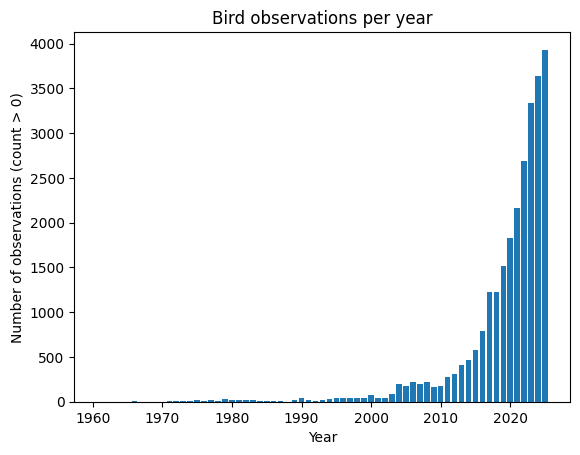

In [54]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_observations_per_year(df: pd.DataFrame) -> None:
    df = df.copy()

    # Ensure datetime
    df['OBSERVATION DATE'] = pd.to_datetime(df['OBSERVATION DATE'])

    # Keep only days with observations
    

    # Count number of observations per year
    yearly_counts = df['OBSERVATION DATE'].dt.year.value_counts().sort_index()

    # Plot
    plt.figure()
    plt.bar(yearly_counts.index, yearly_counts.values)
    plt.xlabel("Year")
    plt.ylabel("Number of observations (count > 0)")
    plt.title("Bird observations per year")
    plt.show()


histemp = historical()
#histemp
plot_observations_per_year(histemp)